In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import numpy as np
import pandas as pd
import scipy.sparse as ssp
from functools import lru_cache
from tqdm import tqdm, trange

import xgboost as xgb 
from sklearn.model_selection import GroupKFold
import time
import matplotlib.pyplot as plt

In [2]:
merged_candidates_feature_test_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates/merged_candidates_test_no_hist_pad_feature.parquet'

In [3]:
@lru_cache(maxsize=1)
def read_merged_candidates_feature_test():
    return pd.read_parquet(merged_candidates_feature_test_path, engine='pyarrow')

In [4]:
test_candidates = read_merged_candidates_feature_test()

In [5]:
test_candidates['sess_locale'] = test_candidates['sess_locale'].astype('category')

In [6]:
FEATURES = ['product_freq', 'product_price', 
            'sasrec_scores_2', 'sasrec_normalized_scores_2', 
            'sasrec_scores_3', 'sasrec_normalized_scores_3',
            'gru4rec_scores', 'gru4rec_normalized_scores',
            'gru4rec_scores_2', 'gru4rec_normalized_scores_2',
            'roberta_scores', 'roberta_normalized_scores',
            'co_graph_counts_0', 'normalized_co_graph_counts_0',
            'co_graph_counts_1', 'normalized_co_graph_counts_1',
            'co_graph_counts_2', 'normalized_co_graph_counts_2',
            'sess_avg_price', 'sess_locale',
            'title_BM25_scores', 'desc_BM25_scores',
            'all_items_co_graph_count_0', 'normalized_all_items_co_graph_count_0',
            'all_items_co_graph_count_1', 'normalized_all_items_co_graph_count_1',
            'all_items_co_graph_count_2', 'normalized_all_items_co_graph_count_2',
            'seqmlp_scores', 'seqmlp_normalized_scores',
            'narm_scores', 'normalized_narm_scores']
FEATURES.sort()
FOLDS = 5
TOPK = 100
ckpt_list = []
for i in range(FOLDS):
    ckpt_list.append(f'./ckpt/XGB_2023_05_20_11_30_32_fold{i}.json')

In [7]:
FEATURES

['all_items_co_graph_count_0',
 'all_items_co_graph_count_1',
 'all_items_co_graph_count_2',
 'co_graph_counts_0',
 'co_graph_counts_1',
 'co_graph_counts_2',
 'desc_BM25_scores',
 'gru4rec_normalized_scores',
 'gru4rec_normalized_scores_2',
 'gru4rec_scores',
 'gru4rec_scores_2',
 'narm_scores',
 'normalized_all_items_co_graph_count_0',
 'normalized_all_items_co_graph_count_1',
 'normalized_all_items_co_graph_count_2',
 'normalized_co_graph_counts_0',
 'normalized_co_graph_counts_1',
 'normalized_co_graph_counts_2',
 'normalized_narm_scores',
 'product_freq',
 'product_price',
 'roberta_normalized_scores',
 'roberta_scores',
 'sasrec_normalized_scores_2',
 'sasrec_normalized_scores_3',
 'sasrec_scores_2',
 'sasrec_scores_3',
 'seqmlp_normalized_scores',
 'seqmlp_scores',
 'sess_avg_price',
 'sess_locale',
 'title_BM25_scores']

In [8]:
preds = np.zeros(len(test_candidates))

for fold in range(FOLDS):
    model = xgb.Booster()
    model.load_model(ckpt_list[fold])
    model.set_param({'predictor': 'gpu_predictor'})
    dtest = xgb.DMatrix(data=test_candidates[FEATURES], enable_categorical=True)
    # dtest = xgb.DMatrix(data=test_candidates[FEATURES])
    preds += model.predict(dtest) / FOLDS

In [9]:
predictions = test_candidates[['sess_id','sess_locale', 'product']].copy()
predictions['pred'] = preds
predictions = predictions.sort_values(['sess_id','pred'], ascending=[True, False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('sess_id')['product'].cumcount().astype('int32')
predictions = predictions.loc[predictions['n'] < TOPK]

In [10]:
sub = pd.DataFrame({})
sub['next_item_prediction'] = predictions.groupby('sess_id')['product'].apply(list)
sub['locale'] = predictions.groupby('sess_id')['sess_locale'].apply(lambda x : x.iloc[0])
sub.reset_index(drop=True, inplace=True)

In [11]:
sub['next_item_prediction'].apply(len).describe()

count    316971.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [ ]:
sub.to_parquet('../predictions/XGBoost/xgboost_05_20_13_32_filter_pad_narm_scores.parquet', engine='pyarrow')

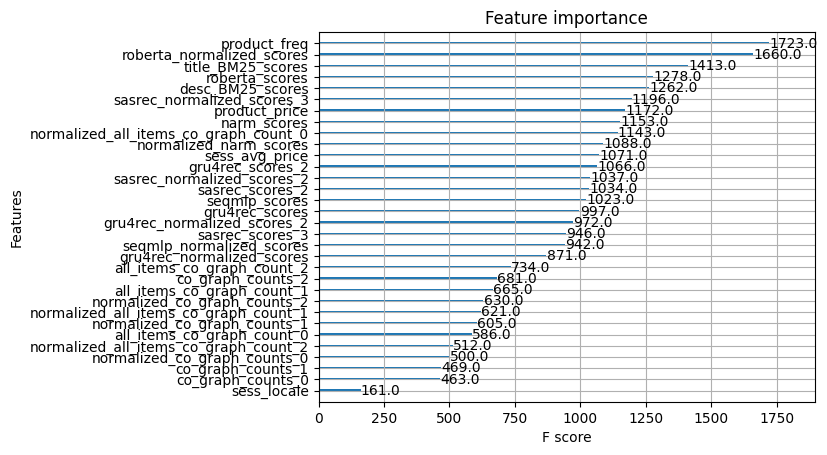

In [13]:
xgb.plot_importance(model)
plt.show()

In [15]:
test_candidates

,sess_id,sess_locale,product,sasrec_scores_2,sasrec_normalized_scores_2,gru4rec_scores,gru4rec_normalized_scores,product_freq,sess_avg_price,product_price,...,sasrec_normalized_scores_3,normalized_all_items_co_graph_count_0,all_items_co_graph_count_0,seqmlp_scores,seqmlp_normalized_scores,desc_BM25_scores,normalized_all_items_co_graph_count_1,all_items_co_graph_count_1,normalized_all_items_co_graph_count_2,all_items_co_graph_count_2
0,0,DE,B000JG2RAG,7.665308,6.347557e-06,8.104032,5.226502e-06,24,25.195269,23.190001,...,1.894552e-05,0.000000,0,8.786958,1.672744e-06,67.792648,0.000000,0.000000,0.000000,0
1,0,DE,B000RYSOUW,-2.951060,1.555882e-10,-2.857798,9.068785e-11,5,25.195269,6.900000,...,5.083796e-10,0.000000,0,-3.325048,9.188664e-12,170.360580,0.000000,0.000000,0.000000,0
2,0,DE,B000UGZVQM,3.977920,1.589257e-07,4.688567,1.717488e-07,4,25.195269,21.990000,...,3.784811e-07,0.000000,0,5.540127,6.506522e-08,71.169296,0.000000,0.000000,0.000000,0
3,0,DE,B000Z6JN7K,6.600063,2.187643e-06,7.367919,2.503351e-06,7,25.195269,13.170000,...,4.662369e-06,0.000000,0,9.692825,4.138498e-06,128.350281,0.000000,0.000000,0.000000,0
4,0,DE,B003CYK6FU,3.741957,1.255211e-07,6.754154,1.355086e-06,4,25.195269,11.990000,...,2.680866e-06,0.000000,0,1.844546,1.615766e-09,142.318924,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61646301,316970,UK,B0BJCTH4NH,11.327528,1.041200e-04,10.629994,3.818184e-04,74,16.950001,5.800000,...,1.849500e-05,0.010237,16,11.838901,9.762144e-04,164.803131,0.002540,1.285714,0.003086,1
61646302,316970,UK,B0BJTQQWLG,5.604142,3.403292e-07,6.052083,3.923694e-06,6,16.950001,9.880000,...,5.044600e-07,0.000640,1,4.890683,9.375031e-07,303.665985,0.000494,0.250000,0.000000,0
61646303,316970,UK,B0BJV3RL4H,9.146974,1.176336e-05,7.667603,1.973815e-05,7,16.950001,22.097065,...,1.265775e-06,0.000640,1,10.187823,1.872800e-04,226.131516,0.001976,1.000000,0.003086,1
61646304,316970,UK,B0BK7SPC84,-10.383047,3.879279e-14,-6.356799,1.601719e-11,0,16.950001,5.960000,...,6.057512e-15,0.000000,0,-4.160688,1.099036e-10,312.603607,0.000000,0.000000,0.000000,0
